# Evaluation

The goal of this lab is to introduce you to techniques for evaluating your trained models. The motivation is to be able to select the model that has the best (expected) out-of-sample prediction and to assess the quality of the model.

## 1. Model Selection in a holdout setting

We will work with the <a href="https://en.wikipedia.org/wiki/Iris_flower_data_set">Iris</a> data set. The iris data set consists out of $4$ features (sepal length, sepal width, petal length, petal width) of three kinds of flowers in the iris family: iris setosa, iris versicolor, iris virginica. Our version of the data set has 150 data points with 50 for each class.

In [1]:
# Load the data
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

iris = load_iris()
print('Loaded {} data points'.format(len(iris.data)))

X, y = iris.data, iris.target

print('Class labels: {}'.format(list(zip(range(3), iris.target_names))))

Loaded 150 data points
Class labels: [(0, 'setosa'), (1, 'versicolor'), (2, 'virginica')]


We try to classify the iris versicolor with the help of the first two features.

In [2]:
import numpy as np

X_versi = X[:, :2] 
y_versi = np.zeros(len(y))
y_versi[y == 1] = 1

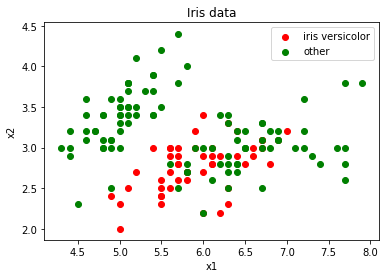

In [3]:
# plot iris data with two features
plt.scatter(X_versi[y_versi == 1, 0], X_versi[y_versi == 1, 1], c='red', label='iris versicolor')
plt.scatter(X_versi[y_versi == 0, 0], X_versi[y_versi == 0, 1], c='green', label='other')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title('Iris data')
plt.legend()
plt.show()

We split the data into a train and test (holdout) set with a split ratio of 75% to 25%.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_versi, y_versi, test_size=0.25, random_state=3)

The following function is a little visualization helper that draws the values of the decision function on a heat map given a matplotlib axe.

In [5]:
def show_decision_function(clf, ax):
    xx, yy = np.meshgrid(np.linspace(4.5, 8, 200), np.linspace(1.5, 4.0, 200))
    try:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    except AttributeError:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]

    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap=plt.cm.jet)
    ax.set_xlim(4.5, 8)
    ax.set_ylim(1.5, 4.0)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=100)

We now train a SVM classifier on the training data and plot its decision boundary.

Text(0.5, 1.0, 'Decision function of a SVM classifier with gamma = 10, C = 1')

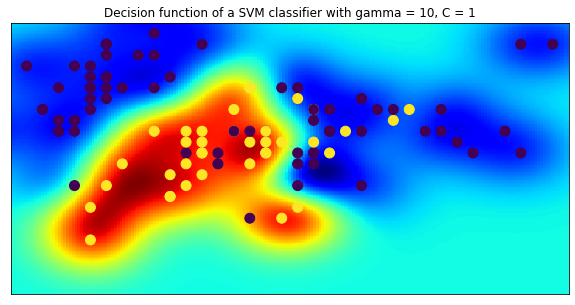

In [6]:
from sklearn.svm import SVC

clf_svm = SVC(gamma=10, C=1)
clf_svm.fit(X_train, y_train)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
show_decision_function(clf_svm, ax)
ax.set_title('Decision function of a SVM classifier with gamma = 10, C = 1')

#### Exercise 1.1 (Performance measures)
Classify the test data and evaluate the classification performance of the trained model 'clf_svm' using the scikit-learn metrics package. Compare various metrics (classification accuracy, precision, recall, f-score), interpret their values and argue which of them might be the most meaningful to report.

In [7]:
from sklearn import metrics

# Classify test data
y_pred = clf_svm.predict(X_test)
acc = metrics.accuracy_score(y_test, y_pred)
prc = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

print('Accuracy:', round(acc, 2))
print('Precision:', round(prc, 2))
print('Recall:', round(rec, 2))
print('F1:', round(f1, 2))

Accuracy: 0.76
Precision: 0.67
Recall: 0.5
F1: 0.57


**Accuracy:** The model classified 76% of the instances correctly, 24% of the instances wrong.

**Precision:** Of the instances classified as "positive" (here: versicolor), 67% of those were actually positive.

**Recall:** Of the instances that are actually versicolors, only 50% were correctly identified as such. (not great)

**F1:** Harmonic mean; the trade-off between precision and recall where the contributions of each are equal: F1 $= \frac{2 (p*r)}{(p+r)}$. Here, the score is 0.57.

- The precision and recall measures are more sophisticated than simply calculating accuracy, so they are more informative to report.
They are combined in the F1 measure, so that would also be nice to report if you want a single number.
- 

#### Exercise 1.2 (ROC curve)

To further evaluate the model, we want to plot a ROC (Receiver operating characteristic) curve and look at the AUC (area under the curve) value. Therefore, we provide a function "plot_roc_curves" that accepts increasing false positive rates (fprs) and true positive rates (tprs) and plots the curve for you. 

Please calculate the false and true positive rates of the classifier 'clf_svm' on the test data 'X_test' and draw the ROC curve by executing the function 'plot_roc_curves'. What does the ROC and AUC tell us about the classifier's performance?

In [8]:
# helper to plot ROC curves
def plot_roc_curves(fprs, tprs):    
    fig = plt.figure(figsize=(20,10))
    
    for fpr, tpr in zip(fprs, tprs):
        plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % metrics.auc(fpr, tpr))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [9]:
# # true positive rate = recall, and false positive rate is 1 - recall
# fpr, tpr = rec, 1-rec
# # But this doesn't work because ^ produces singleton arrays.

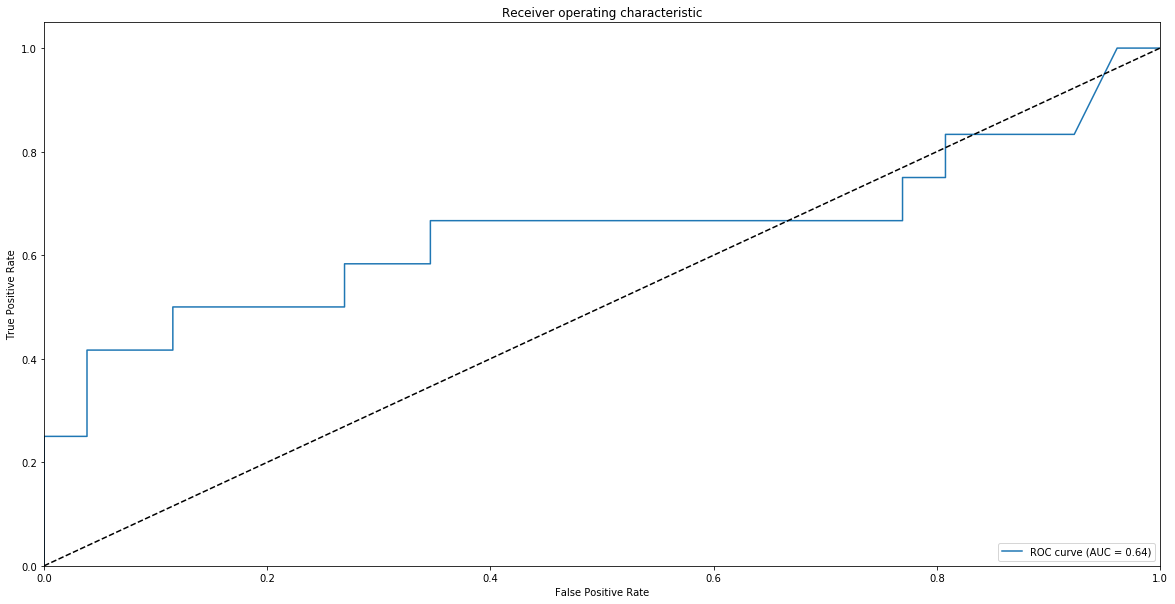

In [10]:
y_score = clf_svm.decision_function(X_test) # different from predict(); the first step of prediction (pre-threshold)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=1)
plot_roc_curves([fpr], [tpr])

#### Exercise 1.3 (Model comparison)

Train four more SVM models on the training data by varying the regularization parameter $C$ (the gamma parameter can be set to 10 again). Put the models into a list 'clfs' using the append method. You can add a name to each classifier by setting clf.name = "some description" to keep track of the configuration.

In [11]:
clfs = []

c_vals = [0.1, 0.5, 1, 10]

for c_val in c_vals:
    clf = SVC(gamma=10, C=c_val)
    clf.fit(X_train, y_train)
    clf.name = 'C = '+str(c_val)
    clfs.append(clf)

Let's have a look at the decision functions of the four classifiers...

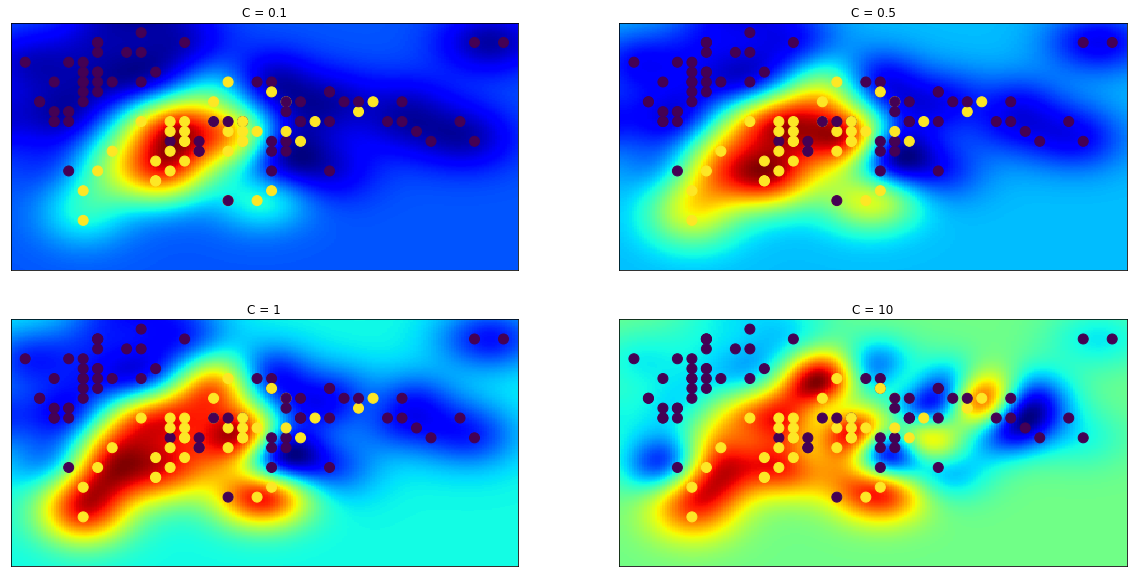

In [12]:
# visualize the decision functions of the four different classifiers
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for clf, ax in zip(clfs, axes.ravel()):
    show_decision_function(clf, ax)
    ax.set_title(clf.name)

... and draw the ROC curves.

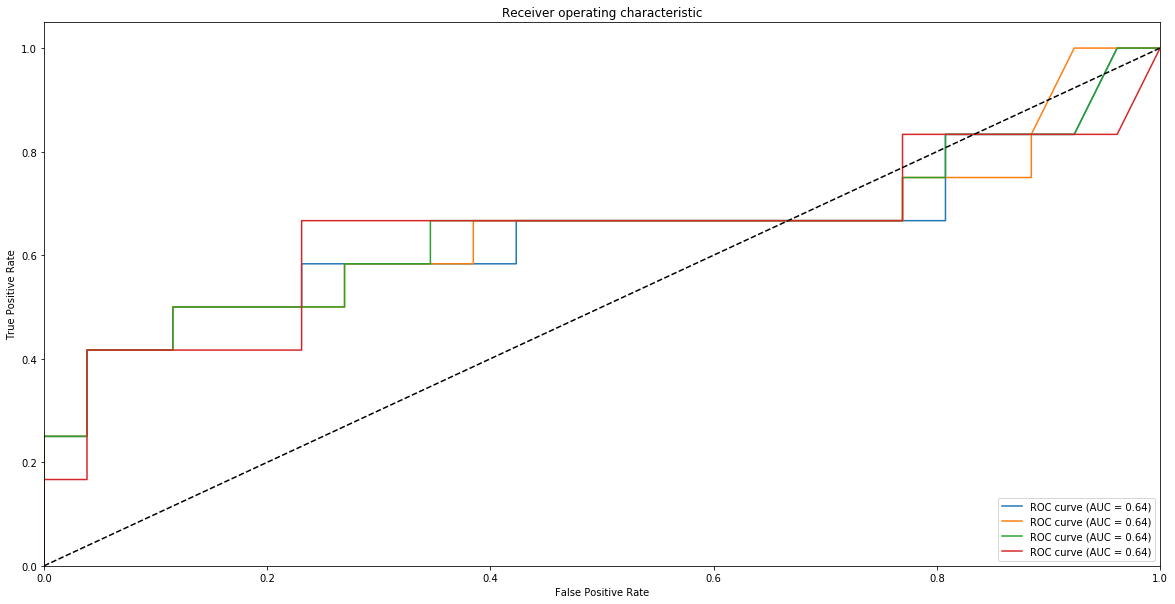

In [13]:
# draw the roc curves:

fprs, tprs = [], []

for clf in clfs:
    y_score = clf.decision_function(X_test)  
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score, pos_label=1)
    fprs.append(fpr)
    tprs.append(tpr)
    
plot_roc_curves(fprs, tprs)

## 2. Hyperparameter Tuning

Many models have hyperparameters, parameters that can't directly be estimated from the data. They have to be manually tuned by the practioner, because there is no analytical formula available to calculate an appropriate value. One example is the regularization parameter $C$ in SVMs.

#### Exercise 2.1 (Nested cross-validation)

Train a SVM classifier for the detection of iris versicolor again, but this time with a proper tuning of the regularization parameter $C$ (you may set the gamma parameter to 10 again). Select a reasonable range of parameter values for $C$ and implement a nested cross-validation (as shown on the slides) by yourself. 

You can use the following helper function that creates a list of masks. Each mask can be used as an index set to select the test samples. The function accepts the number of samples *num_samples* in the dataset and the desired number of folds *k* as input parameters. Since the data is sorted by the labels the k-fold CV will likely have trouble with class imbalances in the some cases. So you should randomly shuffle the data before applying the masks.

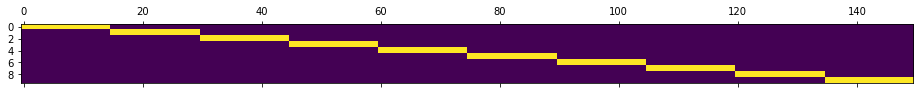

In [14]:
# helper function to create k-fold train-test-splits
def create_kfold_mask(num_samples, k):
    masks = []
    fold_size = num_samples / k
    
    for i in range(k):
        mask = np.zeros(num_samples, dtype=bool)
        mask[int(i*fold_size):int((i+1)*fold_size)] = True
        masks.append(mask)
        
    return masks

# visualization of the splits created by 'create_kfold_mask'
masks = create_kfold_mask(150, 10)
plt.matshow(masks);

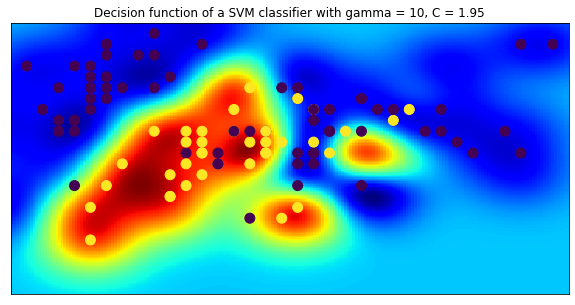

In [17]:
# Randomly shuffle both X_versi and y_versi by shuffling indices and then selecting elements in that
# random order.
rng = np.arange(150)
np.random.shuffle(rng)
X_versi = X_versi[rng]
y_versi = y_versi[rng]

k = 10
masks = create_kfold_mask(150, k)
lbdas = np.linspace(0.1, 10, 100)  # = C values

# Initialise lists to contain all the best lambdas and all empirical risks calculated in the outer loop
fave_lbdas = []
outer_emp_risks = []

# Commence outer loop: iterate over sets.
for i in range(k):
    
    # Remove current outer set idx from list, leaving inner set indices, and split data
    # into test and train for the outer loop.
    inner_sets = list(range(k))
    inner_sets.remove(i)
        
    outer_train_masks = np.max( np.array( [masks[idx] for idx in inner_sets] ) , axis = 0)
    
    X_outer_train, y_outer_train = X_versi[outer_train_masks], y_versi[outer_train_masks]
    X_outer_test, y_outer_test = X_versi[masks[i]], y_versi[masks[i]]

    # Initialise list to collect the mean emp. risks for each value of lambda.
    mean_emp_risks = []
    
    # Iterate over values for lambda.
    for lb in lbdas:
        
        # Initialise list to collect emp risks in inner loop.
        inner_emp_risks = []

        # Commence inner loop: iterate over remaining sets.
        for j in inner_sets:
            
            # Remove j from inner_samples to leave the inner training set, and split data
            # into test and train for the inner loop.
            inner_train = list(inner_sets)
            inner_train.remove(j)
            inner_train_masks = np.max( np.array( [masks[idx] for idx in inner_train] ) , axis = 0)
            
            X_inner_train, y_inner_train = X_versi[inner_train_masks], y_versi[inner_train_masks]
            X_inner_test, y_inner_test = X_versi[masks[j]], y_versi[masks[j]]

            # Train a new model on the inner training data with C=lb.
            clf = SVC(gamma=10, C=lb)
            clf.fit(X_inner_train, y_inner_train)
            
            # Make predictions for the test set.
            y_inner_pred = clf.predict(X_inner_test)
            
            # Empirical risk is the average of the zero-one loss for the test set, which is
            # what's automatically returned by metrics.zero_one_loss (if just want sum, set
            # normalize=False)
            inner_emp_risk = metrics.zero_one_loss(y_inner_test, y_inner_pred)
            inner_emp_risks.append(inner_emp_risk)
            
        # Average empirical risks from inner loop to get mean empirical risk for current lambda.
        mean_emp_risks.append( np.mean(inner_emp_risks) )
        
    # Determine which lambda gives smallest mean empirical risk and add it to list of fave lambdas.
    fave_lbda = lbdas[ np.argmin(mean_emp_risks) ]
    fave_lbdas.append(fave_lbda)
    
    # Using current fave lambda, train a new model on all outer training sets.
    clf = SVC(gamma=10, C=fave_lbda)
    clf.fit(X_outer_train, y_outer_train)
    
    # Get the empirical risk for this model using the outer loop test set.
    y_outer_pred = clf.predict(X_outer_test)
    outer_emp_risk = metrics.zero_one_loss(y_outer_test, y_outer_pred)
    outer_emp_risks.append(outer_emp_risk)

# Average the empirical risks to get overall mean emp. risk (report this); same with lambda.
overall_mean_emp_risk = np.mean(outer_emp_risks)
ultimate_lbda = np.mean(fave_lbdas)

# Train a new model on the entire dataset using the ultimate lambda.
clf = SVC(gamma=10, C=ultimate_lbda)
clf.fit(X_versi, y_versi)

# Plot the thing
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
show_decision_function(clf, ax)
ax.set_title('Decision function of a SVM classifier with gamma = 10, C = '+str(round(ultimate_lbda, 2)));

In [18]:
k = 4
lbdas = np.linspace(0.1, 1, 3)  # = C values

for i in range(1, k+1):
    print('. S', i, '= outer test set')
    
    # (remove current outer set idx from list to iterate over below) 
    inner_sets = list(range(1, k+1))
    inner_sets.remove(i)
    
    # Iterate over values for lambda, let's just do a few to start
    for lb in lbdas:
        print('. . lambda', lb)

        # Iterate over remaining sample sets
        for j in inner_sets:
            
            # Remove j from inner_samples to leave the inner training set
            inner_train = list(inner_sets)
            inner_train.remove(j)
            print('. . .  Train a new model on sets', inner_train)            
            print('. . .  Get empirical risk for model using test set', j)
            
        print('. . Average the empirical risks from inner loop to get mean emp. risk for lambda =', lb)
    
    print('. Determine which value of lambda in', lbdas, 'gives smallest mean emp risk and set as lb*')
    print('. Train a new model on set', inner_sets, 'using lb*')
    print('. Get empirical risk for model using test set', i,'\n')
    
print('Average the empirical risks from outer loop to get grand mean emp. risk')
print('Average all of the best lambdas from outer loop to get ultimate lambda')
print('Train a new model on all sets in', list(range(1, k+1)))
print('Return model and grand mean emp. risk')

. S 1 = outer test set
. . lambda 0.1
. . .  Train a new model on sets [3, 4]
. . .  Get empirical risk for model using test set 2
. . .  Train a new model on sets [2, 4]
. . .  Get empirical risk for model using test set 3
. . .  Train a new model on sets [2, 3]
. . .  Get empirical risk for model using test set 4
. . Average the empirical risks from inner loop to get mean emp. risk for lambda = 0.1
. . lambda 0.55
. . .  Train a new model on sets [3, 4]
. . .  Get empirical risk for model using test set 2
. . .  Train a new model on sets [2, 4]
. . .  Get empirical risk for model using test set 3
. . .  Train a new model on sets [2, 3]
. . .  Get empirical risk for model using test set 4
. . Average the empirical risks from inner loop to get mean emp. risk for lambda = 0.55
. . lambda 1.0
. . .  Train a new model on sets [3, 4]
. . .  Get empirical risk for model using test set 2
. . .  Train a new model on sets [2, 4]
. . .  Get empirical risk for model using test set 3
. . .  Train